In [1]:
import numpy as np
import matplotlib.pyplot as plt
from videoreader import VideoReader
import xarray as xr
import xarray_behave as xb


plt.style.use('ncb.mplstyle')

## assembling data

In [2]:
# CHANGE THESE
root = "/Volumes/ukme04/#Data/chainingmic/"
dat_path = "dat.processed"
datename = "localhost-20181120_144618"

# assemble data
ds = xb.assemble(datename, root=root, dat_path=dat_path)
ds


/Users/clemens10/Library/CloudStorage/Dropbox/code.py/xarray_behave/src/xarray_behave/loaders.py:139: UserWarning: loadtxt: Empty input file: "/Volumes/ukme04/#Data/chainingmic/res/localhost-20181120_144618/localhost-20181120_144618_idswaps.txt"
  a = np.loadtxt(filepath)  # dtype=np.uintp)


<xarray.Dataset>
Dimensions:              (sampletime: 6180000, channels: 16,
                          no_song_channels: 2, time: 603502, event_types: 7,
                          event_time: 2, index: 4848, bodyparts: 3, coords: 2,
                          flies: 2, poseparts: 12)
Coordinates:
  * sampletime           (sampletime) float64 0.0 9.99e-05 ... 618.0 618.0
  * time                 (time) float64 0.0 0.0009997 0.001999 ... 603.5 603.5
  * event_types          (event_types) <U21 'song_pulse_any_fss' ... 'copulat...
    event_categories     (event_types) <U7 'event' 'event' ... 'event' 'segment'
  * event_time           (event_time) <U13 'start_seconds' 'stop_seconds'
  * bodyparts            (bodyparts) <U6 'head' 'center' 'tail'
  * coords               (coords) <U1 'y' 'x'
  * flies                (flies) int64 0 1
    chambers             (flies) int64 0 0
    nearest_frame        (time) int64 622 623 623 623 ... 60930 60930 60930
  * poseparts            (poseparts) <U16 'head' 'neck' ... 'right_wing' 'tail'
Dimensions without coordinates: channels, no_song_channels, index
Data variables:
    song_raw             (sampletime, channels) float64 1.89 1.705 ... 1.891
    non_song_raw         (sampletime, no_song_channels) float64 -0.0001906 .....
    song_events          (time, event_types) int16 0 0 0 0 0 0 0 ... 1 1 0 0 0 0
    event_times          (index, event_time) float64 1.104 1.104 ... nan 0.0
    event_names          (index) <U128 'song_pulse_any_fss' ... 'sine_fss'
    body_positions       (time, flies, bodyparts, coords) float64 840.5 ... 3...
    pose_positions       (time, flies, poseparts, coords) float64 -25.55 ... ...
    pose_positions_allo  (time, flies, poseparts, coords) float64 834.5 ... 3...
Attributes:
    video_filename:           /Volumes/ukme04/#Data/chainingmic/dat.processed...
    datename:                 localhost-20181120_144618
    root:                     /Volumes/ukme04/#Data/chainingmic/
    dat_path:                 dat.processed
    res_path:                 res
    sampling_rate_Hz:         10000.0
    target_sampling_rate_Hz:  1000
    ref_time:                 1542721585.5441856
    swap_events:              []

In [3]:
# assemble metrics
dsm = xb.assemble_metrics(ds)
dsm


/Users/clemens10/Library/CloudStorage/Dropbox/code.py/xarray_behave/src/xarray_behave/metrics.py:278: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(dot_v1_v2 / np.sqrt(dot_v1_v1 * dot_v2_v2))


<xarray.Dataset>
Dimensions:            (time: 603502, absolute_features: 16, flies: 2,
                        relative_features: 6, relative_flies: 2)
Coordinates:
  * time               (time) float64 0.0 0.0009997 0.001999 ... 603.5 603.5
  * absolute_features  (absolute_features) <U23 'angles' ... 'wing_angle_sum'
    nearest_frame      (time) int64 622 623 623 623 ... 60930 60930 60930 60930
  * relative_features  (relative_features) <U25 'distance' ... 'relative_velo...
Dimensions without coordinates: flies, relative_flies
Data variables:
    abs_features       (time, flies, absolute_features) float32 -8.21 ... 11.18
    rel_features       (time, flies, relative_flies, relative_features) float32 ...

# raw data
It's apparent that due to the interpolation, the raw data are 'jumpy'. Therefore we need to smooth the data with a running moving average (with a window of 100 steps).

In [4]:
# Load video
video_ext = ".mp4"
videoname = f"{root}/{dat_path}/{datename}/{datename}{video_ext}"
vr = VideoReader(videoname)
vr


/Volumes/ukme04/#Data/chainingmic//dat.processed/localhost-20181120_144618/localhost-20181120_144618.mp4 with 60932 frames of size (920, 912, 3) at 100.00 fps

(89700.0, 91200.0)

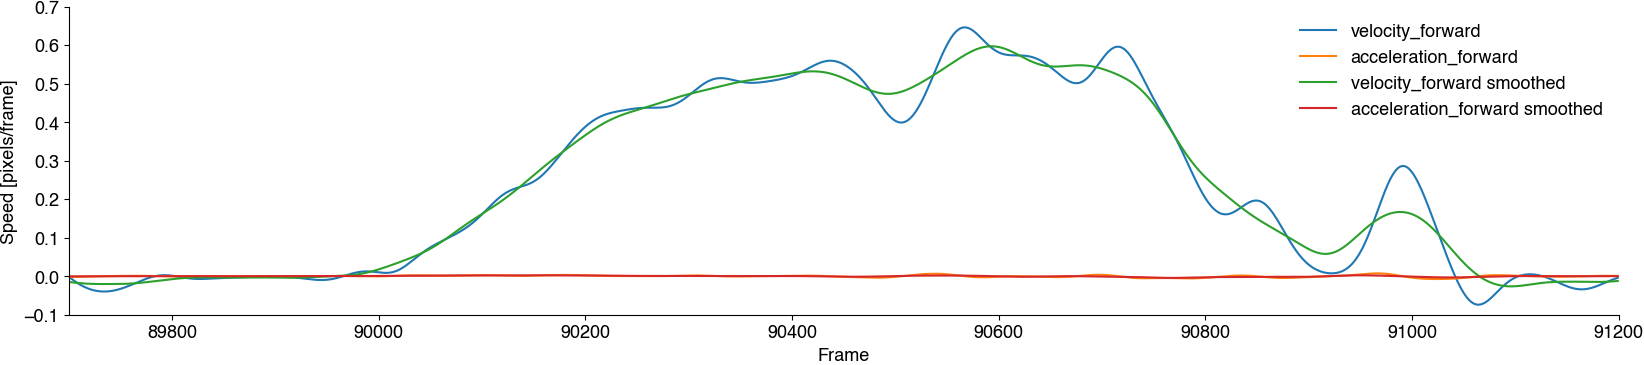

In [5]:
idx_0 = 89700
idx_1 = 91200

focal_fly = 0
other_fly = 1

# raw data
features = ["velocity_forward", "acceleration_forward"]
fig = plt.figure(figsize=(20, 4))
for ifeature in features:
    plt.plot(np.arange(idx_0, idx_1), dsm.abs_features.sel(absolute_features=ifeature).values[idx_0:idx_1, focal_fly], label=ifeature)
plt.ylabel("Speed [pixels/frame]")
plt.xlabel("Frame")
plt.legend()

# smoothed data
steps = 100
for ifeature in features:
    smoothed = np.convolve(
        np.squeeze(dsm.abs_features.sel(absolute_features=ifeature).values[idx_0:idx_1, focal_fly]),
        np.ones(steps, dtype=int) / steps,
        "same",
    )
    plt.plot(np.arange(idx_0, idx_1), smoothed, label=ifeature + ' smoothed')
plt.legend()
plt.xlim(idx_0, idx_1)


## how to access data?

In [6]:
# loading position coordinate (x) of a body part (head)
head_x = ds.pose_positions_allo.sel(poseparts="head", coords="x").values[idx_0:idx_1:steps, focal_fly]
head_x

array([483.39921794, 479.14591857, 479.04146139, 477.75421436,
       480.45864199, 494.99836681, 511.49670241, 523.94835314,
       544.09296332, 574.73741591, 607.22825581, 629.92194246,
       638.54574784, 647.51104715, 655.78080414])

## example of velocities for a moving fly

rotational speed, forward velocity and lateral velocity

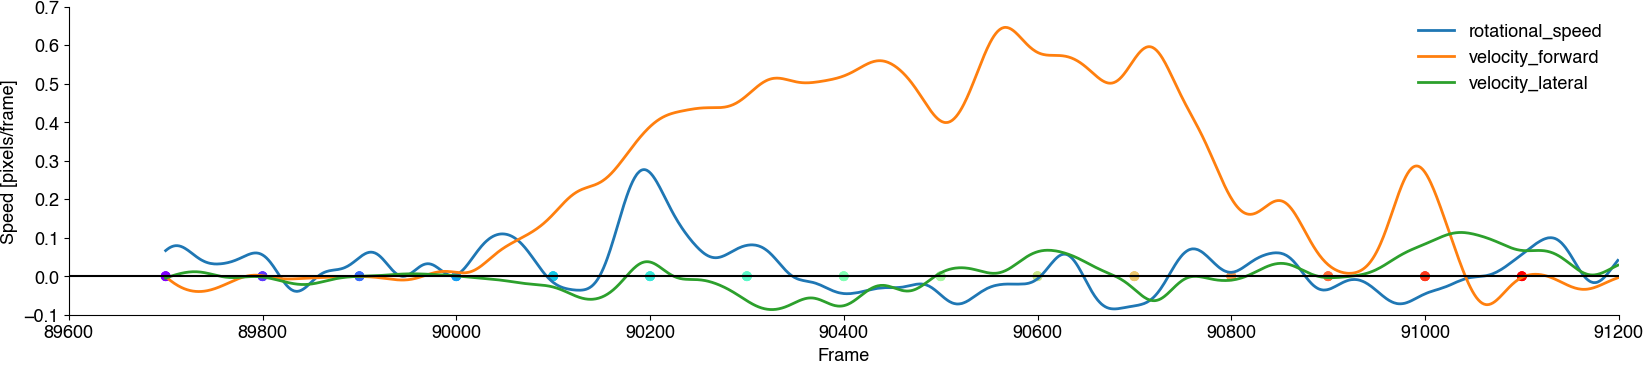

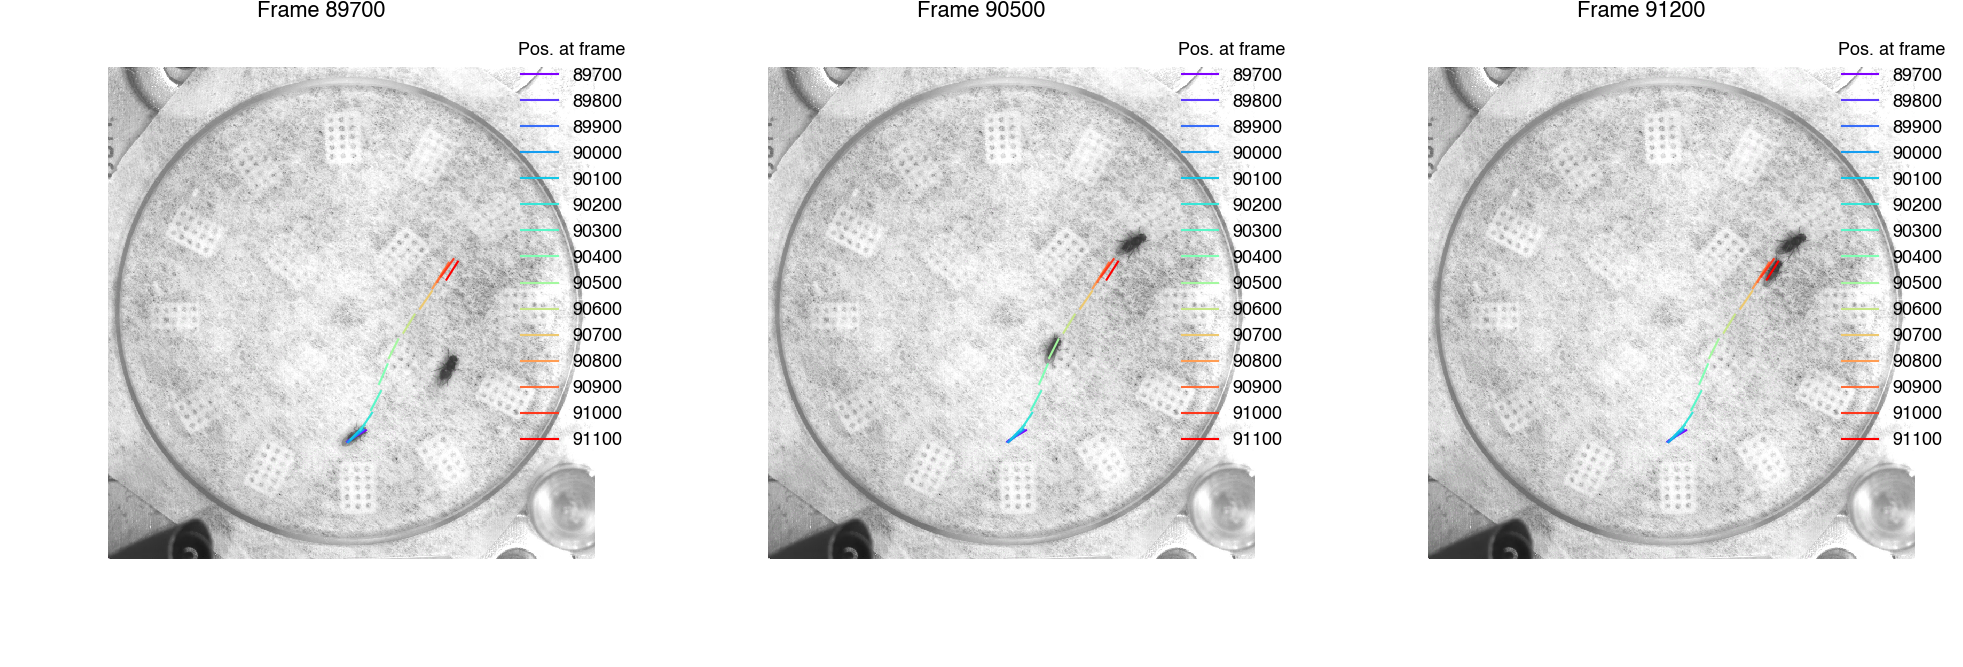

In [7]:

features = ["rotational_speed", "velocity_forward", "velocity_lateral"]

xs = np.arange(idx_0, idx_1, steps)
colors = plt.cm.rainbow(np.linspace(0, 1, len(xs)))

plt.figure(figsize=(20, 4))
for ifeature in features:
    data = dsm.abs_features.sel(absolute_features=ifeature).values[idx_0:idx_1, focal_fly]
    plt.plot(np.arange(idx_0, idx_1), data, label=ifeature, linewidth=2)

    plt.scatter(xs, np.zeros_like(xs), c=colors)
    plt.ylabel("Speed [pixels/frame]")
    plt.xlabel("Frame")
    plt.legend()
plt.axhline(0, c="k")
plt.show()

steps = 100
head_x = ds.pose_positions_allo.sel(poseparts="head", coords="x").values[idx_0:idx_1:steps, [focal_fly]][:, 0]
head_y = ds.pose_positions_allo.sel(poseparts="head", coords="y").values[idx_0:idx_1:steps, [focal_fly]][:, 0]
thorax_x = ds.pose_positions_allo.sel(poseparts="tail", coords="x").values[idx_0:idx_1:steps, [focal_fly]][:, 0]
thorax_y = ds.pose_positions_allo.sel(poseparts="tail", coords="y").values[idx_0:idx_1:steps, [focal_fly]][:, 0]

# three example frames
example_frames = [idx_0, idx_1 - 700, idx_1]
plt.figure(figsize=(20, 12))
for cnt, iframe in enumerate(example_frames):
    plt.subplot(1, 3, cnt + 1)
    fn = int(ds.pose_positions_allo.nearest_frame[iframe])  # get frame number for that idx
    frame = vr[fn]
    plt.imshow(frame, cmap="Greys")

    plt.gca().set_prop_cycle(plt.cycler("color", colors))
    plt.plot((head_x, thorax_x), (head_y, thorax_y))
    plt.xlim(0, frame.shape[0])
    plt.ylim(0, frame.shape[0])
    plt.legend(xs, title="Pos. at frame")
    plt.title(f"Frame {iframe}")
    plt.axis("square")
    plt.axis("off")
plt.tight_layout()
plt.show()


## example of all components and magnitudes for velocities and accelerations
x and y component (relative to chamber), forward and lateral component (relative to fly), and velocity magnitude (speed)

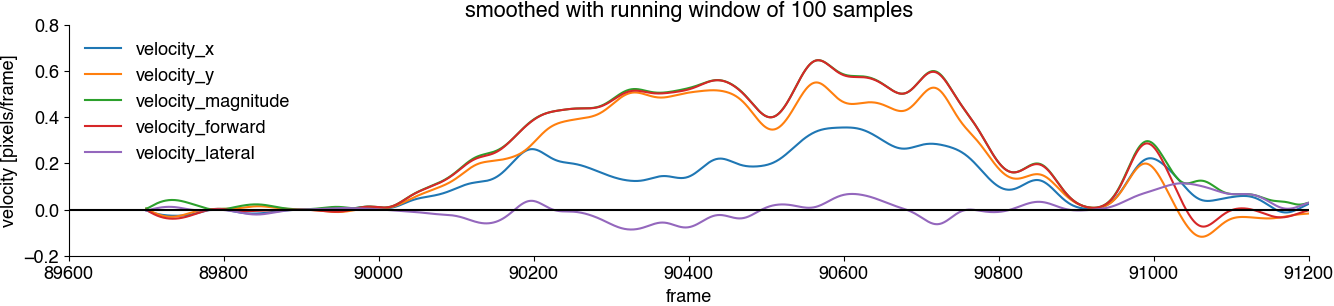

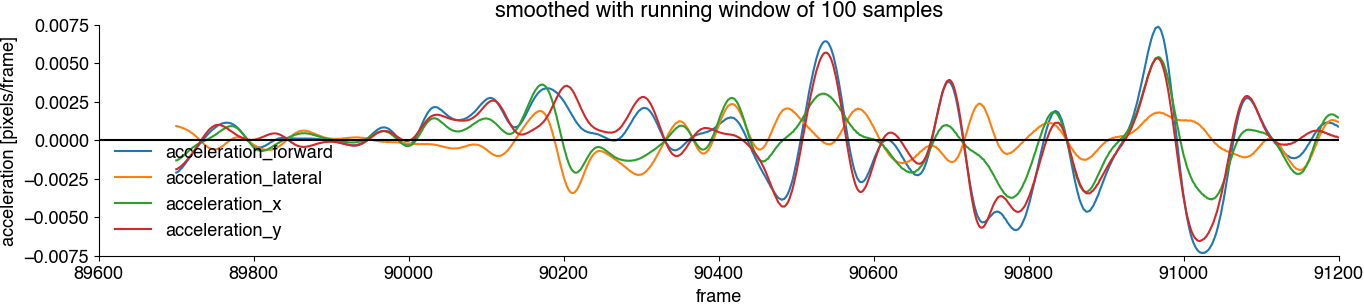

In [8]:
features = ["velocity_x", "velocity_y", "velocity_magnitude", "velocity_forward", "velocity_lateral"]

fig = plt.figure(figsize=(16, 3))
for ifeature in features:
    fv = dsm.abs_features.sel(absolute_features=ifeature).values[idx_0:idx_1, focal_fly]
    plt.plot(np.arange(idx_0, idx_1), fv, label=ifeature)

plt.axhline(0, c='k')
plt.title(f"smoothed with running window of {steps} samples")
plt.ylabel("velocity [pixels/frame]")
plt.xlabel("frame")
plt.legend()
plt.show()


features = [
    "acceleration_forward",
    "acceleration_lateral",
    "acceleration_x",
    "acceleration_y",
]

fig = plt.figure(figsize=(16, 3))
for ifeature in features:
    fv = dsm.abs_features.sel(absolute_features=ifeature).values[idx_0:idx_1, focal_fly]
    plt.plot(np.arange(idx_0, idx_1), fv, label=ifeature)
plt.axhline(0, c='k')
plt.title(f"smoothed with running window of {steps} samples")
plt.ylabel("acceleration [pixels/frame]")
plt.xlabel("frame")
plt.legend()
plt.show()


## illustration of angle variables
relative orientation: difference between the orientation of the body axes

relative angle: angle at which the thorax of other flies is found relative to the reference fly's orientation

657.6219342102022

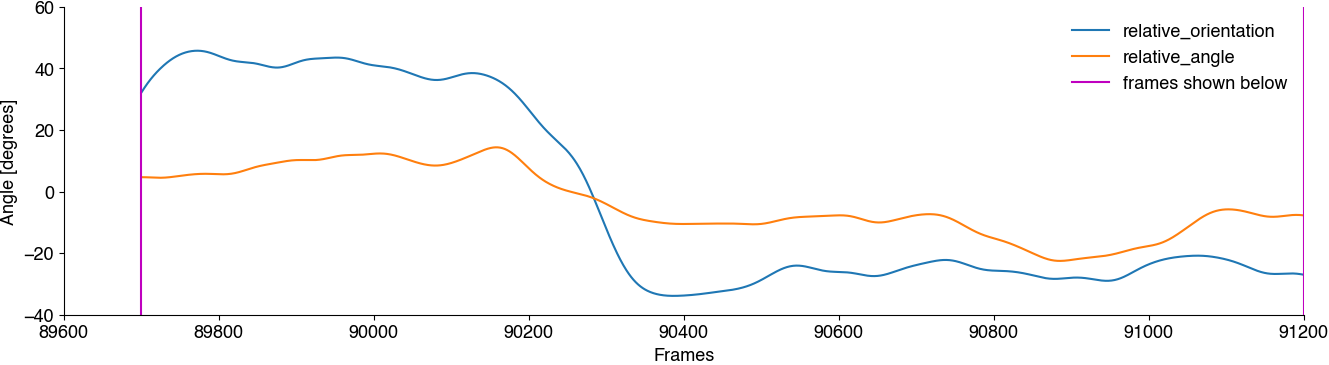

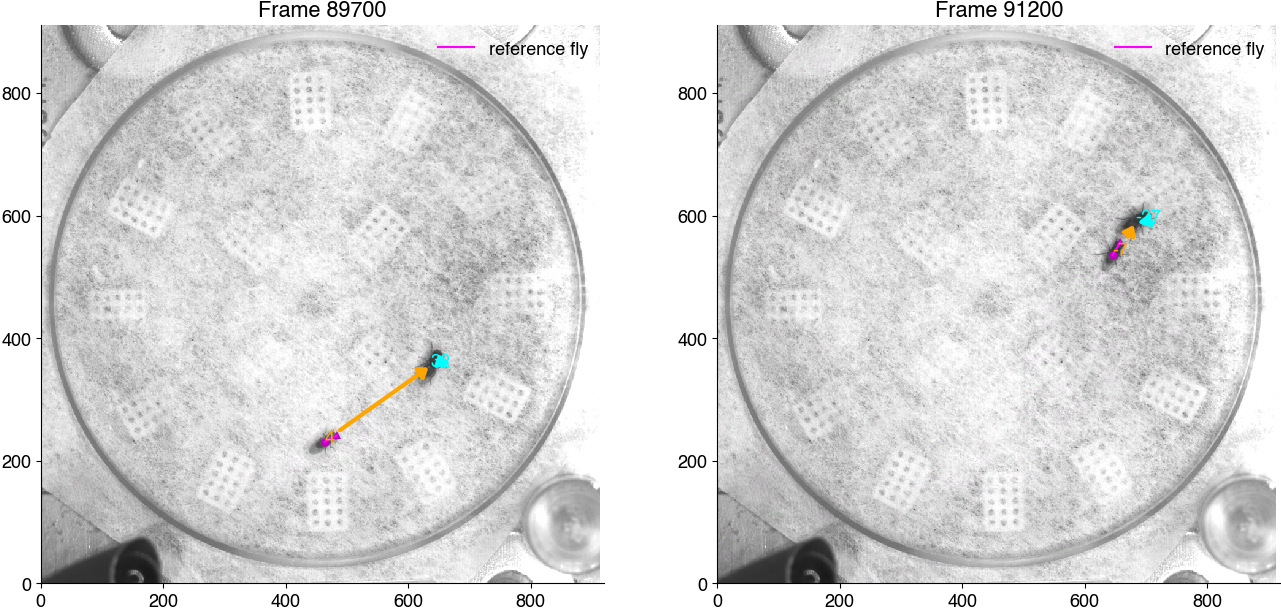

In [21]:
# demo for angles
features = ["relative_orientation", "relative_angle"]

fig = plt.figure(figsize=(16, 4))
for ifeature in features:
    plt.plot(
        np.arange(idx_0, idx_1),
        dsm.rel_features.sel(relative_features=ifeature).values[idx_0:idx_1, focal_fly, other_fly],
        label=ifeature,
    )
plt.ylabel("Angle [degrees]")
plt.xlabel("Frames")
plt.axvline(idx_0, c="m", label="frames shown below")
plt.axvline(idx_1, c="m")
plt.legend()
plt.show()


fig = plt.figure(figsize=(16, 8))
for cnt, idx in enumerate([idx_0, idx_1]):
    head_x = ds.pose_positions_allo.sel(poseparts="head", coords="x", flies=focal_fly).values[idx]
    head_y = ds.pose_positions_allo.sel(poseparts="head", coords="y", flies=focal_fly).values[idx]
    thorax_x = ds.pose_positions_allo.sel(poseparts="thorax", coords="x", flies=focal_fly).values[idx]
    thorax_y = ds.pose_positions_allo.sel(poseparts="thorax", coords="y", flies=focal_fly).values[idx]

    other_x = ds.pose_positions_allo.sel(poseparts="thorax", coords="x", flies=other_fly).values[idx]
    other_y = ds.pose_positions_allo.sel(poseparts="thorax", coords="y", flies=other_fly).values[idx]
    other_head_x = ds.pose_positions_allo.sel(poseparts="head", coords="x", flies=other_fly).values[idx]
    other_head_y = ds.pose_positions_allo.sel(poseparts="head", coords="y", flies=other_fly).values[idx]

    fn = int(ds.pose_positions_allo.nearest_frame[idx])  # get frame number for that idx
    frame = vr[fn]

    plt.subplot(1, 2, cnt + 1)
    plt.imshow(frame, cmap="Greys")
    plt.gca().set_aspect("equal")

    # reference fly
    plt.plot(thorax_x, thorax_y, "mo")
    plt.plot(head_x, head_y, "m^")
    plt.plot((head_x, thorax_x), (head_y, thorax_y), color="magenta", label="reference fly")

    # the relative angle of the reference fly is the angle of the reference fly relative to the angle between both flies
    rel_angle = int(dsm.rel_features.sel(relative_features="relative_angle").values[idx, focal_fly, other_fly])
    plt.annotate(
        f"{rel_angle}",
        xy=(other_x, other_y),
        xytext=(thorax_x, thorax_y),
        arrowprops=dict(arrowstyle="-|>, head_width=0.3", color="orange", lw=3),
        color="orange",
    )

    # the orientation of the other fly is the other flies angle relative to the angle of the reference fly
    rel_orientation = int(dsm.rel_features.sel(relative_features="relative_orientation").values[idx, focal_fly, other_fly])
    plt.annotate(
        f"{rel_orientation}",
        xy=(other_head_x, other_head_y),
        xytext=(other_x, other_y),
        arrowprops=dict(arrowstyle="-|>, head_width=0.3", color="cyan", lw=3),
        color="cyan",
    )

    plt.legend()
    plt.title(f"Frame {idx}")
    plt.xlim(0, frame.shape[0])
    plt.ylim(0, frame.shape[1])
plt.show()
